### seq2seq

References:
*   https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
*   https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
*   https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb




In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from tensorflow.keras import regularizers
import datetime
import pandas as pd
from google.colab import files

In [ ]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [ ]:
!pip install --user kaggle
!mv /usr/local/lib/python3.7/dist-packages/kaggle /root/

In [ ]:
from google.colab import files
# Get kaggle.json from your kaggle account page
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle competitions download -c m5-forecasting-accuracy

 58% 9.00M/15.5M [00:00<00:00, 39.0MB/s]
100% 15.5M/15.5M [00:00<00:00, 51.8MB/s]
 32% 5.00M/15.8M [00:00<00:00, 30.1MB/s]
100% 15.8M/15.8M [00:00<00:00, 62.9MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 113MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 165MB/s]
 63% 9.00M/14.2M [00:00<00:00, 40.4MB/s]
100% 14.2M/14.2M [00:00<00:00, 56.4MB/s]


In [ ]:
!unzip -q sales_train_evaluation.csv.zip -d .
!unzip -q sales_train_validation.csv.zip -d .

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
import pandas as pd

import re
import numpy as np

preproc_dir = "/gdrive/MyDrive/Forecasting - DSI Capstone Spring '21/Colabs/preprocessed_data/"

train_ca1_store = pd.read_pickle(preproc_dir+'train_ca1_store.pkl')
train_ca1_store_product = pd.read_pickle(preproc_dir+'train_ca1_store_product.pkl')

Mounted at /gdrive


In [ ]:
LEVEL = 'store'
if LEVEL == 'store':
    df = train_ca1_store.copy()
elif LEVEL == 'store_product':
    df = train_ca1_store_product.copy()

In [ ]:
# Read in the original data for univariate comparison
orig = pd.read_csv('./sales_train_validation.csv')

# Keep just 'CA_1' store and the date range from the 
# preprocessed file
orig = orig.loc[orig.store_id == 'CA_1']
d_min = f"d_{df['d'].min()}"
d_max = f"d_{df['d'].max()}"

# filter on one item_id
# orig = orig.loc[orig.item_id == 'HOUSEHOLD_2_175']

# Keep just the id's that are in both datasets
orig = orig.loc[orig.store_id.isin(df.store_id)]
orig = orig.loc[:, d_min:d_max]

# Sum up total daily sales
orig = orig.sum(0)

In [ ]:
# Fix columns names
unique_cols = np.unique(pd.Series(df.columns).str.replace("\_x$|\_y$", "").values)
new_cols = list(pd.Series(df.columns).str.replace("\_y$", "").values)
df.columns = new_cols
drop_cols =  list(df.columns[pd.Series(df.columns).str.contains("\_x$").values])
df.drop(columns = drop_cols, inplace=True)

df.head()

,store_id,d,sales,date,snap_CA,tm_d,tm_w,tm_m,tm,tm_wm,tm_dw,tm_w_end,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,sales_lag_35,sales_lag_36,sales_lag_37,sales_lag_38,sales_lag_39,sales_lag_40,sales_lag_41,sales_lag_42,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_tmp_1_7,rolling_mean_tmp_1_14,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60,enc_store_id_mean,enc_store_id_std,event_name_1_lencoded,event_type_1_lencoded,event_name_2_lencoded,event_type_2_lencoded
0,CA_1,1069,2912.0,2014-01-01,1,1,1,1,0,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4364.0,918.0,18,1,2,2
1,CA_1,1070,4408.0,2014-01-02,1,2,1,1,0,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4364.0,918.0,30,4,2,2
2,CA_1,1071,4704.0,2014-01-03,1,3,1,1,0,1,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4364.0,918.0,30,4,2,2
3,CA_1,1072,5088.0,2014-01-04,1,4,1,1,0,1,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4364.0,918.0,30,4,2,2
4,CA_1,1073,5472.0,2014-01-05,1,5,1,1,0,1,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4364.0,918.0,30,4,2,2


In [ ]:
# split into train and test sets
train = df.loc[df.d < 1799]
val = df.loc[df.d >= 1799]
print(f'train dim: {train.shape}')
print(f'val dim: {val.shape}')

train.drop(columns = ['store_id','date', 'd'], inplace=True)
val.drop(columns = ['store_id','date', 'd'], inplace=True)

train dim: (730, 55)
val dim: (28, 55)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Store-level univariate seq2seq
Train a seq2seq model just using the daily store-wide sales.

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 56, 28

# split into input and outputs
univ_sales = orig.values
univ_sales_train_test = univ_sales[:-1*(n_steps_out+n_steps_in)]
univ_sales_val = univ_sales[-1*(n_steps_out+n_steps_in):]

# define input sequence
print(univ_sales_train_test.shape)

assert len(univ_sales_train_test)+len(univ_sales_val) == len(univ_sales), \
"individual sets do not match original set"

# split into samples
univ_X, univ_y = split_sequence(univ_sales_train_test, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
univ_X = univ_X.reshape((univ_X.shape[0], univ_X.shape[1], n_features))
univ_y = univ_y.reshape((univ_y.shape[0], univ_y.shape[1], n_features))
print(f'univ_X dims: {univ_X.shape}')
print(f'univ_y dims: {univ_y.shape}')

(674,)
univ_X dims: (591, 56, 1)
univ_y dims: (591, 28, 1)


In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
# define model
# Keep LSTM layer's parameters as-is to take advantage of CUDNN GPU:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1
model_cudnn = Sequential()
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
               #    bias_regularizer=regularizers.l2(1e-4),
               input_shape=(univ_X.shape[1], univ_X.shape[2])))
model_cudnn.add(RepeatVector(n_steps_out))
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
            #    bias_regularizer=regularizers.l2(1e-4),
               return_sequences=True))
model_cudnn.add(TimeDistributed(Dense(1)))
model_cudnn.compile(optimizer='adam',
              loss='mse',
            #   metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )
model_cudnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 28, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 100)           80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
# Take log1p of values for training, then take the inverse on the predictions
# for comparison to the actual values

univ_X_test = univ_X[:-1*n_steps_out,:,:]
univ_y_test = univ_y[:-1*n_steps_out]
univ_X_val = univ_X[-1*(n_steps_out+n_steps_in):,:,:]
univ_y_val = univ_y[-1*(n_steps_out+n_steps_in):]

history = model_cudnn.fit(#univ_X[:-28,:,:], 
                    np.log1p(univ_X_test),
                    np.log1p(univ_y_test),
                    # Keep epochs >= 500 for good results
                    epochs=1000, 
                    batch_size=32, 
                    validation_data=(np.log1p(univ_X_val), 
                                     np.log1p(univ_y_val)),
                    verbose=2)

Epoch 1/1000
18/18 - 34s - loss: 21.6732 - val_loss: 2.2679
Epoch 2/1000
18/18 - 0s - loss: 1.6390 - val_loss: 0.9252
Epoch 3/1000
18/18 - 0s - loss: 0.8237 - val_loss: 0.5466
Epoch 4/1000
18/18 - 0s - loss: 0.5954 - val_loss: 0.4191
Epoch 5/1000
18/18 - 0s - loss: 0.4802 - val_loss: 0.3172
Epoch 6/1000
18/18 - 0s - loss: 0.4035 - val_loss: 0.2545
Epoch 7/1000
18/18 - 0s - loss: 0.3464 - val_loss: 0.2037
Epoch 8/1000
18/18 - 0s - loss: 0.3016 - val_loss: 0.1641
Epoch 9/1000
18/18 - 0s - loss: 0.2665 - val_loss: 0.1318
Epoch 10/1000
18/18 - 0s - loss: 0.2393 - val_loss: 0.1076
Epoch 11/1000
18/18 - 0s - loss: 0.2191 - val_loss: 0.0897
Epoch 12/1000
18/18 - 0s - loss: 0.2034 - val_loss: 0.0750
Epoch 13/1000
18/18 - 0s - loss: 0.1915 - val_loss: 0.0675
Epoch 14/1000
18/18 - 0s - loss: 0.1829 - val_loss: 0.0593
Epoch 15/1000
18/18 - 0s - loss: 0.1766 - val_loss: 0.0533
Epoch 16/1000
18/18 - 0s - loss: 0.1721 - val_loss: 0.0487
Epoch 17/1000
18/18 - 0s - loss: 0.1690 - val_loss: 0.0459
Epoc

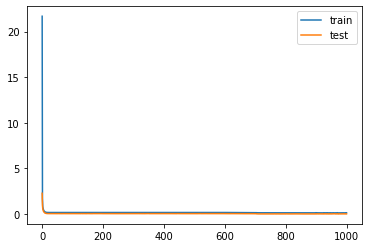

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:

univ_X_val, univ_y_val = split_sequence(univ_sales_val, n_steps_in, n_steps_out)
# x_input = test_y[0:10]
univ_X_val = univ_X_val.reshape((univ_X_val.shape[0], n_steps_in, n_features))
# univ_X_val = univ_sales[-56:-28]
# univ_y_val = univ_sales[-28:-21]
# univ_X_val = univ_X_val.reshape((1, 28, 1))


In [ ]:

y_pred = np.expm1(model_cudnn.predict(np.log1p(univ_X_val), verbose=0))

# y_pred = model.predict(univ_X_val, verbose=0)
# print(yhat)

In [ ]:
test_preds = np.expm1(model_cudnn.predict(np.log1p(univ_X_test), verbose=0))
residuals = univ_y_test - test_preds
residuals = np.reshape(residuals, (residuals.shape[0], residuals.shape[1]))

bootstrap_d = {}

quantiles_l = []

q = [0.01, 0.05, 0.165, 0.25, 0.5, 0.75, 0.835, 0.95, 0.99]
for c in range(residuals.shape[1]):
    quantiles_c = np.quantile(a=residuals[:,c], q=q)
    quantiles_c = np.reshape(quantiles_c, (1, len(q)))
    quantiles_c = pd.DataFrame(quantiles_c, columns = [str(i) for i in q])
    quantiles_c['pred_d'] = c
    quantiles_l.append(quantiles_c)

quantiles_df = pd.concat(quantiles_l)

quantiles_df.to_csv("seq2seq_store_quantiles.csv", index = False)


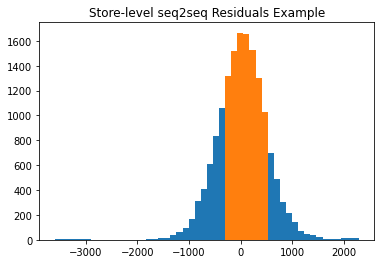

In [ ]:
# Plot residuals as example
import matplotlib.pyplot as plt

residuals_plt = residuals.reshape((residuals.shape[0]*residuals.shape[1]))
N, bins, patches = plt.hist(residuals_plt, bins = 50)
plt.title("Store-level seq2seq Residuals Example")
for i in range(len(bins)):
    if bins[i] >= quantiles_df['0.165'].values[0] and bins[i] <= quantiles_df['0.835'].values[0]:
        patches[i].set_facecolor('C1')

plt.show()

In [ ]:
univ_comp = pd.DataFrame({'y_pred':np.reshape(y_pred, (28)), 
                          'y_val':np.reshape(univ_y_val, (28))})

univ_comp = pd.concat([univ_comp.reset_index(drop=True), 
                       quantiles_df.reset_index(drop=True)], 
                      axis=1)

for i in q:
    univ_comp[str(i)] = univ_comp[str(i)] + univ_comp['y_pred']

''

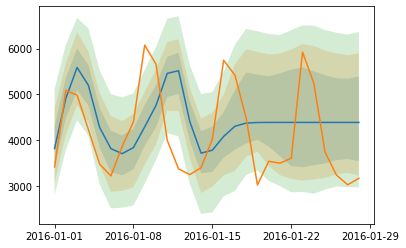

In [ ]:

tick_idxs = [0,7,14,21,28]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in tick_idxs]
dates = [i.strftime('%Y-%m-%d') for i in dates]

import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(univ_comp['y_pred'])
ax.plot(univ_comp['y_val'])
ax.fill_between([i for i in range(28)], 
                univ_comp['0.165'], 
                univ_comp['0.835'], 
                alpha=0.2)
ax.fill_between([i for i in range(28)], 
                univ_comp['0.05'], 
                univ_comp['0.95'], 
                alpha=0.2)
ax.fill_between([i for i in range(28)], 
                univ_comp['0.01'], 
                univ_comp['0.99'], 
                alpha=0.2)
ax.set_xticks(ticks=tick_idxs)
ax.set_xticklabels(labels=dates)
;
# ax.plot(x, y, 'o', color='tab:brown')


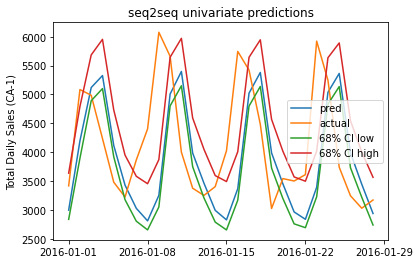

In [ ]:
pyplot.plot(univ_comp['y_pred'], label='pred')
pyplot.plot(univ_comp['y_val'], label='actual')
pyplot.plot(univ_comp['0.165'], label='68% CI low')
pyplot.plot(univ_comp['0.835'], label='68% CI high')
pyplot.title('seq2seq univariate predictions')
# 2016-01-11

tick_idxs = [0,7,14,21,28]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in tick_idxs]
dates = [i.strftime('%Y-%m-%d') for i in dates]

pyplot.xticks(ticks=tick_idxs, labels=dates)
pyplot.ylabel('Total Daily Sales (CA-1)')
# pyplot.xticks(dates)
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_log_error
rmse1 = mean_squared_error(y_true=univ_comp['y_val'], y_pred=univ_comp['y_pred'], squared=False)
print(f"RMSE: {round(rmse1,2)}")

RMSE: 14.18


In [ ]:
# Write to CSV
univ_comp = univ_comp.reset_index(drop=True)
univ_comp.drop(columns='y_val', inplace=True)
univ_comp.rename(columns={'y_pred':'predicted_sales'}, inplace=True)
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in range(28)]
dates = [i.strftime('%Y-%m-%d') for i in dates]

univ_comp['date'] = dates
univ_comp['model'] = 'seq2seq'
univ_comp['item_id'] = 'HOUSEHOLD_2_175'
univ_comp['d'] = ['d_'+str(d) for d in range(1799,1827)]
univ_comp.to_csv("seq2seq_HOUSEHOLD_2_175.csv", index=False)

,predicted_sales,date,model
0,30.743565,2016-01-01,seq2seq
1,35.986492,2016-01-02,seq2seq
2,45.771061,2016-01-03,seq2seq
3,49.452049,2016-01-04,seq2seq
4,35.134914,2016-01-05,seq2seq
5,32.565254,2016-01-06,seq2seq
6,33.714130,2016-01-07,seq2seq
7,34.185360,2016-01-08,seq2seq
8,42.281147,2016-01-09,seq2seq
9,47.947311,2016-01-10,seq2seq


### Store-Level seq2seq with Exogenous Variables
Train a store-level seq2seq model with the dataset with engineered features.

In [ ]:
n_steps_in = 56
n_steps_out = 28

In [ ]:
train2 = train.dropna(axis=1)
test2 = train2.iloc[-200:-1*n_steps_in, :]
val2 = train2.iloc[-1*n_steps_in:, :]
train2 = train2.iloc[:-200,:]

In [ ]:
# train2_X, train2_y = train2.drop(columns='sales'), train2['sales']
# test2_X, test2_y = test2.drop(columns='sales'), test2['sales']
train2_X, train2_y = train2, train2['sales']
test2_X, test2_y = test2, test2['sales']

In [ ]:
train2_X = train2_X.values
test2_X = test2_X.values
train2_y = train2_y.values
test2_y = test2_y.values

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train2_X = train2_X.reshape((train2_X.shape[0], 1, train2_X.shape[1]))
test2_X = test2_X.reshape((test2_X.shape[0], 1, test2_X.shape[1]))
print(train2_X.shape, train2_y.shape, test2_X.shape, test2_y.shape)

(530, 1, 15) (530,) (144, 1, 15) (144,)


In [ ]:
start_idx_X = 0
stop_idx_X = start_idx_X + n_steps_in

start_idx_y = n_steps_in
stop_idx_y = n_steps_in+n_steps_out

X_l = []
y_l = []

# (n_series, n_timesteps, n_features)

while stop_idx_y < train2.shape[0]:
    seq_X = train2_X[start_idx_X:stop_idx_X]
    seq_X = seq_X.reshape(1, seq_X.shape[0], seq_X.shape[2])
    seq_y = train2_y[start_idx_y:stop_idx_y]
    seq_y = seq_y.reshape(1, seq_y.shape[0])
    X_l.append(seq_X)
    y_l.append(seq_y)
    start_idx_X += 1
    stop_idx_X += 1
    start_idx_y += 1
    stop_idx_y += 1

train2_X = np.concatenate(X_l, axis=0)
train2_y = np.concatenate(y_l, axis=0)

In [ ]:

print(train2_X.shape)

(446, 56, 15)


In [ ]:


start_idx_X = 0
stop_idx_X = start_idx_X + n_steps_in

start_idx_y = n_steps_in
stop_idx_y = n_steps_in+n_steps_out

X_l = []
y_l = []

# (n_series, n_timesteps, n_features)

while stop_idx_y < test2.shape[0]:
    seq_X = test2_X[start_idx_X:stop_idx_X]
    seq_X = seq_X.reshape(1, seq_X.shape[0], seq_X.shape[2])
    seq_y = test2_y[start_idx_y:stop_idx_y]
    seq_y = seq_y.reshape(1, seq_y.shape[0])
    X_l.append(seq_X)
    y_l.append(seq_y)
    start_idx_X += 1
    stop_idx_X += 1
    start_idx_y += 1
    stop_idx_y += 1

test2_X = np.concatenate(X_l, axis=0)
test2_y = np.concatenate(y_l, axis=0)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', 
            #    bias_regularizer=regularizers.l2(1e-4),
               input_shape=(train2_X.shape[1], train2_X.shape[2])))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', 
            #    bias_regularizer=regularizers.l2(1e-4),
               return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam',
              loss='mse',
            #   metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               46400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 28, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 28, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 28, 1)             101       
Total params: 126,901
Trainable params: 126,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(datetime.datetime.now())

2021-03-29 17:00:53.675136


In [ ]:
# fit model
# tf.random.set_seed(0)

history2 = model.fit(np.log1p(train2_X),
                     np.log1p(train2_y),
                     epochs=1000, batch_size=32, 
                     validation_data=(np.log1p(test2_X), np.log1p(test2_y)),
                     verbose=2)

Epoch 1/1000
14/14 - 6s - loss: 44.2367 - val_loss: 4.8209
Epoch 2/1000
14/14 - 1s - loss: 2.6032 - val_loss: 1.2479
Epoch 3/1000
14/14 - 1s - loss: 1.0887 - val_loss: 0.3923
Epoch 4/1000
14/14 - 2s - loss: 0.4030 - val_loss: 0.1948
Epoch 5/1000
14/14 - 1s - loss: 0.2542 - val_loss: 0.2730
Epoch 6/1000
14/14 - 2s - loss: 0.2290 - val_loss: 0.1494
Epoch 7/1000
14/14 - 1s - loss: 0.2221 - val_loss: 0.0721
Epoch 8/1000
14/14 - 1s - loss: 0.2160 - val_loss: 0.1044
Epoch 9/1000
14/14 - 1s - loss: 0.2092 - val_loss: 0.0766
Epoch 10/1000
14/14 - 1s - loss: 0.2051 - val_loss: 0.0742
Epoch 11/1000
14/14 - 1s - loss: 0.2045 - val_loss: 0.0619
Epoch 12/1000
14/14 - 1s - loss: 0.2035 - val_loss: 0.0659
Epoch 13/1000
14/14 - 1s - loss: 0.2035 - val_loss: 0.0469
Epoch 14/1000
14/14 - 1s - loss: 0.2045 - val_loss: 0.0605
Epoch 15/1000
14/14 - 1s - loss: 0.2047 - val_loss: 0.0480
Epoch 16/1000
14/14 - 1s - loss: 0.2031 - val_loss: 0.0585
Epoch 17/1000
14/14 - 1s - loss: 0.2005 - val_loss: 0.0460
Epoch

In [ ]:
print(datetime.datetime.now())

2021-03-29 17:20:25.528264


In [ ]:
model.save("seq2seq_store_level")

INFO:tensorflow:Assets written to: seq2seq_store_level/assets


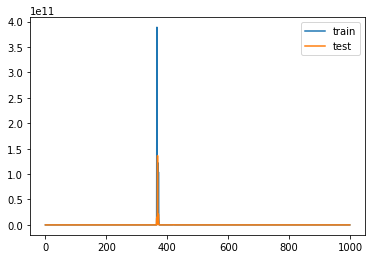

In [ ]:
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Read in the original data for univariate comparison
orig = pd.read_csv('./sales_train_validation.csv')

# Keep just 'CA_1' store and the date range from the 
# preprocessed file
orig = orig.loc[orig.store_id == 'CA_1']
d_min = f"d_{df['d'].min()}"
d_max = f"d_{df['d'].max()}"

# Keep just the id's that are in both datasets
orig = orig.loc[orig.store_id.isin(df.store_id)]
orig = orig.loc[:, d_min:d_max]

# Sum up total daily sales
orig = orig.sum(0)

In [ ]:
val_X, val_y = val2, orig[-28:]
from sklearn.impute import SimpleImputer
val_X=SimpleImputer(strategy='mean').fit_transform(val_X)

In [ ]:
# val_X = val_X.values
val_X = val_X.reshape(1, val_X.shape[0], val_X.shape[1])

In [ ]:
y_pred2 = np.expm1(model.predict(np.log1p(val_X), verbose=0))

In [ ]:
comp2 = pd.DataFrame({'y_pred':np.reshape(y_pred2, (28)), 
                      'y_val':np.reshape(val_y, (28))})

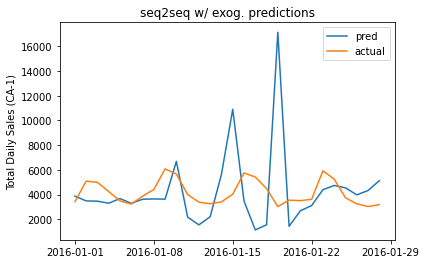

In [ ]:
pyplot.plot(comp2['y_pred'], label='pred')
pyplot.plot(comp2['y_val'], label='actual')
pyplot.title('seq2seq w/ exog. predictions')
# 2016-01-11

tick_idxs = [0,7,14,21,28]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in tick_idxs]
dates = [i.strftime('%Y-%m-%d') for i in dates]

pyplot.xticks(ticks=tick_idxs, labels=dates)
pyplot.ylabel('Total Daily Sales (CA-1)')
# pyplot.xticks(dates)
pyplot.legend()
pyplot.show()

In [ ]:
rmse2 = mean_squared_error(y_true=comp2['y_val'], 
                           y_pred=comp2['y_pred'], squared=False)
print(f"RMSE: {round(rmse2,2)}")

RMSE: 3381.55


In [ ]:
# Write to CSV
comp2 = comp2.reset_index(drop=True)
comp2.drop(columns='y_val', inplace=True)
comp2.rename(columns={'y_pred':'pred_sales'}, inplace=True)
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in range(28)]
dates = [i.strftime('%Y-%m-%d') for i in dates]

comp2['date'] = dates
comp2['d'] = ['d_'+str(d) for d in range(1799,1827)]
comp2['model'] = 'seq2seq'
comp2 = comp2[['d','date','pred_sales','model']]
comp2.to_csv("seq2seq_exog_store_preds_2021-03-28.csv", index = False)

#### Univariate store-product level


In [ ]:
LEVEL = 'store_product'
if LEVEL == 'store':
    df = train_ca1_store.copy()
elif LEVEL == 'store_product':
    df = train_ca1_store_product.copy()

In [ ]:
# Read in the original data for univariate comparison
orig = pd.read_csv('./sales_train_validation.csv')

# Keep just 'CA_1' store and the date range from the 
# preprocessed file
orig = orig.loc[orig.store_id == 'CA_1']
d_min = f"d_{df['d'].min()}"
d_max = f"d_{df['d'].max()}"

# Keep just the id's that are in both datasets
orig = orig.loc[orig.store_id.isin(df.store_id)]


In [ ]:
orig_item_id = orig.item_id
orig = orig.loc[:, d_min:d_max]

# DON'T sum up total daily sales

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
sales = orig.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
train = sales.iloc[:,:-28].values
test = sales.iloc[:,-1*(56+28):].values

In [ ]:
print(train.shape)
print(test.shape)

(3049, 730)
(3049, 84)


In [ ]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 56, 28

# split into input and outputs

univ_sales_train = train[:-1000,:-1*(n_steps_out+n_steps_in)]
univ_sales_val = train[-1000:,-1*(n_steps_out+n_steps_in):]


In [ ]:
# define input sequence
print(univ_sales_train.shape)
print(univ_sales_val.shape)

(2049, 646)
(1000, 84)


In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_train.shape[0]):
    univ_X_train, univ_y_train = split_sequence(univ_sales_train[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_train)
    y_l.append(univ_y_train)

univ_X_train = np.concatenate(X_l, axis=0)
univ_y_train = np.concatenate(y_l, axis=0)

In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_val.shape[0]):
    univ_X_val, univ_y_val = split_sequence(univ_sales_val[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_val)
    y_l.append(univ_y_val)

univ_X_val = np.concatenate(X_l, axis=0)
univ_y_val = np.concatenate(y_l, axis=0)

In [ ]:
n_features = 1
univ_X_train = univ_X_train.reshape((univ_X_train.shape[0], univ_X_train.shape[1], n_features))
univ_y_train = univ_y_train.reshape((univ_y_train.shape[0], univ_y_train.shape[1], n_features))
univ_X_val = univ_X_val.reshape((univ_X_val.shape[0], univ_X_val.shape[1], n_features))
univ_y_val = univ_y_val.reshape((univ_y_val.shape[0], univ_y_val.shape[1], n_features))

In [ ]:
print(f'univ_X_train dims: {univ_X_train.shape}')
print(f'univ_y_train dims: {univ_y_train.shape}')
print(f'univ_X_val dims: {univ_y_val.shape}')
print(f'univ_y_val dims: {univ_y_val.shape}')

univ_X_train dims: (1153587, 56, 1)
univ_y_train dims: (1153587, 28, 1)
univ_X_val dims: (1000, 28, 1)
univ_y_val dims: (1000, 28, 1)


In [ ]:
# define model
# Keep LSTM layer's parameters as-is to take advantage of CUDNN GPU:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1
model_cudnn = Sequential()
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
               #    bias_regularizer=regularizers.l2(1e-4),
               input_shape=(univ_X_train.shape[1], univ_X_train.shape[2])))
model_cudnn.add(RepeatVector(n_steps_out))
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
            #    bias_regularizer=regularizers.l2(1e-4),
               return_sequences=True))
model_cudnn.add(TimeDistributed(Dense(1)))
model_cudnn.compile(optimizer='adam',
              loss='mse',
            #   metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )
model_cudnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 28, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 28, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 28, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
# tf.random.set_seed(0)

history2 = model_cudnn.fit(univ_X_train[0:30000], 
                           univ_y_train[0:30000],
                           epochs=300, batch_size=32,
                           validation_data=(univ_X_val, univ_y_val),
                           verbose=2)

Epoch 1/300
938/938 - 39s - loss: 2.8357 - val_loss: 6.2654
Epoch 2/300
938/938 - 5s - loss: 2.7838 - val_loss: 6.4478
Epoch 3/300
938/938 - 5s - loss: 2.7507 - val_loss: 6.4527
Epoch 4/300
938/938 - 5s - loss: 2.7366 - val_loss: 6.2269
Epoch 5/300
938/938 - 5s - loss: 2.7165 - val_loss: 6.6147
Epoch 6/300
938/938 - 5s - loss: 2.6997 - val_loss: 6.5021
Epoch 7/300
938/938 - 5s - loss: 2.6727 - val_loss: 6.6647
Epoch 8/300
938/938 - 5s - loss: 2.6508 - val_loss: 6.5840
Epoch 9/300
938/938 - 5s - loss: 2.6261 - val_loss: 6.8242
Epoch 10/300
938/938 - 5s - loss: 2.5993 - val_loss: 6.8522
Epoch 11/300
938/938 - 5s - loss: 2.5773 - val_loss: 6.7591
Epoch 12/300
938/938 - 5s - loss: 2.5766 - val_loss: 6.9803
Epoch 13/300
938/938 - 5s - loss: 2.5315 - val_loss: 6.8931
Epoch 14/300
938/938 - 5s - loss: 2.5201 - val_loss: 6.7876
Epoch 15/300
938/938 - 5s - loss: 2.4959 - val_loss: 6.7753
Epoch 16/300
938/938 - 5s - loss: 2.4798 - val_loss: 7.0216
Epoch 17/300
938/938 - 5s - loss: 2.4572 - val_l

In [ ]:
test_X = orig.values[:, -84:-28]
test_y = orig.values[:, -28:]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
# Make predictions
y_pred = model_cudnn.predict(test_X, verbose=0)

In [ ]:
train_preds = model_cudnn.predict(univ_X_train[0:30000], verbose=0)

In [ ]:
train_preds = model_cudnn.predict(univ_X_train[0:30000], verbose=0)
residuals = univ_y_train[0:30000] - train_preds
residuals = np.reshape(residuals, (residuals.shape[0], residuals.shape[1]))

bootstrap_d = {}

quantiles_l = []

q = [0.01, 0.05, 0.165, 0.25, 0.5, 0.75, 0.835, 0.95, 0.99]
for c in range(residuals.shape[1]):
    quantiles_c = np.quantile(a=residuals[:,c], q=q)
    quantiles_c = np.reshape(quantiles_c, (1, len(q)))
    quantiles_c = pd.DataFrame(quantiles_c, columns = [str(i) for i in q])
    quantiles_c['pred_d'] = c
    quantiles_l.append(quantiles_c)

quantiles_df = pd.concat(quantiles_l)

quantiles_df.to_csv("seq2seq_store_product_quantiles.csv", index = False)


In [ ]:
# Reshape predictions into CSV format
export_file = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
export_file = pd.DataFrame(export_file)
export_file = export_file.transpose()
export_file.columns = [c for c in orig_item_id.values]
export_file['d'] = ['d_'+str(d) for d in range(1799,1827)]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in range(28)]
dates = [i.strftime('%Y-%m-%d') for i in dates]
export_file['date'] = dates
export_file = pd.melt(export_file,  id_vars = ('d', 'date'), value_name = 'pred_sales', var_name='item_id')
export_file.to_csv("seq2seq_store_product_epochs=300.csv")

In [ ]:
comp3 = pd.DataFrame({'y_pred':np.reshape(y_pred[100], (28)), 
                      'y_val':np.reshape(test_y[100], (28))})

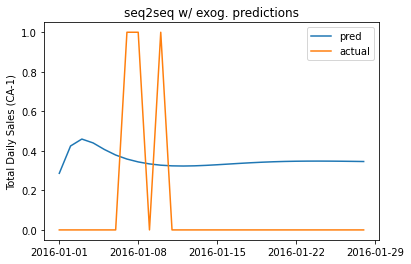

In [ ]:
pyplot.plot(comp3['y_pred'], label='pred')
pyplot.plot(comp3['y_val'], label='actual')
pyplot.title('seq2seq w/ exog. predictions')
# 2016-01-11

tick_idxs = [0,7,14,21,28]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in tick_idxs]
dates = [i.strftime('%Y-%m-%d') for i in dates]

pyplot.xticks(ticks=tick_idxs, labels=dates)
pyplot.ylabel('Total Daily Sales (CA-1)')
# pyplot.xticks(dates)
pyplot.legend()
pyplot.show()

### Univariate product-level (HOBBIES)

In [ ]:
LEVEL = 'store_product'
if LEVEL == 'store':
    df = train_ca1_store.copy()
elif LEVEL == 'store_product':
    df = train_ca1_store_product.copy()

In [ ]:
# Read in the original data for univariate comparison
orig = pd.read_csv('./sales_train_validation.csv')

# Keep just 'CA_1' store and the date range from the 
# preprocessed file
orig = orig.loc[(orig.store_id == 'CA_1') & (orig.cat_id == 'HOBBIES')]
d_min = f"d_{df['d'].min()}"
d_max = f"d_{df['d'].max()}"

# Keep just the id's that are in both datasets
orig = orig.loc[orig.store_id.isin(df.store_id)]


In [ ]:
orig_item_id = orig.item_id
orig = orig.loc[:, d_min:d_max]

# DON'T sum up total daily sales

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
sales = orig.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
train = sales.iloc[:,:-28].values
test = sales.iloc[:,-1*(56+28):].values

In [ ]:
print(train.shape)
print(test.shape)

(565, 730)
(565, 84)


In [ ]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 56, 28

# split into input and outputs

univ_sales_train = train[:-250,:-200]
univ_sales_val = train[-250:,-200:]
# univ_sales_train = train[:-250,:-1*(n_steps_out+n_steps_in)]
# univ_sales_val = train[-250:,-1*(n_steps_out+n_steps_in):]


In [ ]:
# define input sequence
print(univ_sales_train.shape)
print(univ_sales_val.shape)

(315, 530)
(250, 200)


In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_train.shape[0]):
    univ_X_train, univ_y_train = split_sequence(univ_sales_train[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_train)
    y_l.append(univ_y_train)

univ_X_train = np.concatenate(X_l, axis=0)
univ_y_train = np.concatenate(y_l, axis=0)

In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_val.shape[0]):
    univ_X_val, univ_y_val = split_sequence(univ_sales_val[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_val)
    y_l.append(univ_y_val)

univ_X_val = np.concatenate(X_l, axis=0)
univ_y_val = np.concatenate(y_l, axis=0)

In [ ]:
n_features = 1
univ_X_train = univ_X_train.reshape((univ_X_train.shape[0], univ_X_train.shape[1], n_features))
univ_y_train = univ_y_train.reshape((univ_y_train.shape[0], univ_y_train.shape[1], n_features))
univ_X_val = univ_X_val.reshape((univ_X_val.shape[0], univ_X_val.shape[1], n_features))
univ_y_val = univ_y_val.reshape((univ_y_val.shape[0], univ_y_val.shape[1], n_features))

In [ ]:
print(f'univ_X_train dims: {univ_X_train.shape}')
print(f'univ_y_train dims: {univ_y_train.shape}')
print(f'univ_X_val dims: {univ_y_val.shape}')
print(f'univ_y_val dims: {univ_y_val.shape}')

univ_X_train dims: (140805, 56, 1)
univ_y_train dims: (140805, 28, 1)
univ_X_val dims: (29250, 28, 1)
univ_y_val dims: (29250, 28, 1)


In [ ]:
# define model
# Keep LSTM layer's parameters as-is to take advantage of CUDNN GPU:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1
model_cudnn = Sequential()
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
               #    bias_regularizer=regularizers.l2(1e-4),
               input_shape=(univ_X_train.shape[1], univ_X_train.shape[2])))
model_cudnn.add(RepeatVector(n_steps_out))
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
            #    bias_regularizer=regularizers.l2(1e-4),
               return_sequences=True))
model_cudnn.add(TimeDistributed(Dense(1)))
model_cudnn.compile(optimizer='adam',
              loss='mse',
            #   metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )
model_cudnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 28, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 28, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 28, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
# tf.random.set_seed(0)

history2 = model_cudnn.fit(univ_X_train[0:30000], 
                           univ_y_train[0:30000],
                           epochs=300, batch_size=32,
                           validation_data=(univ_X_val, univ_y_val),
                           verbose=2)

Epoch 1/300
938/938 - 41s - loss: 7.4989 - val_loss: 4.7713
Epoch 2/300
938/938 - 7s - loss: 7.2416 - val_loss: 4.8295
Epoch 3/300
938/938 - 7s - loss: 7.1921 - val_loss: 4.9288
Epoch 4/300
938/938 - 7s - loss: 7.1481 - val_loss: 4.8924
Epoch 5/300
938/938 - 7s - loss: 7.1180 - val_loss: 4.8189
Epoch 6/300
938/938 - 7s - loss: 7.0840 - val_loss: 4.9319
Epoch 7/300
938/938 - 7s - loss: 7.0560 - val_loss: 4.9173
Epoch 8/300
938/938 - 8s - loss: 7.0390 - val_loss: 4.9703
Epoch 9/300
938/938 - 7s - loss: 7.0080 - val_loss: 4.8821
Epoch 10/300
938/938 - 7s - loss: 6.9942 - val_loss: 5.0083
Epoch 11/300
938/938 - 7s - loss: 6.9649 - val_loss: 4.9809
Epoch 12/300
938/938 - 7s - loss: 6.9526 - val_loss: 4.9466
Epoch 13/300
938/938 - 7s - loss: 6.9301 - val_loss: 4.9707
Epoch 14/300
938/938 - 7s - loss: 6.9053 - val_loss: 4.9805
Epoch 15/300
938/938 - 7s - loss: 6.8814 - val_loss: 5.0361
Epoch 16/300
938/938 - 7s - loss: 6.8567 - val_loss: 4.9812
Epoch 17/300
938/938 - 7s - loss: 6.8601 - val_l

In [ ]:
test_X = orig.values[:, -84:-28]
test_y = orig.values[:, -28:]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
# Make predictions
y_pred = model_cudnn.predict(test_X, verbose=0)

In [ ]:
train_preds = model_cudnn.predict(univ_X_train[0:30000], verbose=0)

In [ ]:
# Reshape predictions into CSV format
export_file = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
export_file = pd.DataFrame(export_file)
export_file = export_file.transpose()
export_file.columns = [c for c in orig_item_id.values]
export_file['d'] = ['d_'+str(d) for d in range(1799,1827)]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in range(28)]
dates = [i.strftime('%Y-%m-%d') for i in dates]
export_file['date'] = dates
export_file = pd.melt(export_file,  id_vars = ('d', 'date'), value_name = 'pred_sales', var_name='item_id')
export_file.to_csv("seq2seq_HOBBIES.csv")

### Univariate product-level (FOOD)

In [ ]:
LEVEL = 'store_product'
if LEVEL == 'store':
    df = train_ca1_store.copy()
elif LEVEL == 'store_product':
    df = train_ca1_store_product.copy()

In [ ]:
# Read in the original data for univariate comparison
orig = pd.read_csv('./sales_train_validation.csv')

# Keep just 'CA_1' store and the date range from the 
# preprocessed file
orig = orig.loc[(orig.store_id == 'CA_1') & (orig.cat_id == 'FOODS')]
d_min = f"d_{df['d'].min()}"
d_max = f"d_{df['d'].max()}"

# Keep just the id's that are in both datasets
orig = orig.loc[orig.store_id.isin(df.store_id)]


In [ ]:
orig_item_id = orig.item_id
orig = orig.loc[:, d_min:d_max]

# DON'T sum up total daily sales

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
sales = orig.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
train = sales.iloc[:,:-28].values
test = sales.iloc[:,-1*(56+28):].values

In [ ]:
print(train.shape)
print(test.shape)

(1437, 730)
(1437, 84)


In [ ]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 56, 28

# split into input and outputs

univ_sales_train = train[:-250,:-200]
univ_sales_val = train[-250:,-200:]
# univ_sales_train = train[:-250,:-1*(n_steps_out+n_steps_in)]
# univ_sales_val = train[-250:,-1*(n_steps_out+n_steps_in):]


In [ ]:
# define input sequence
print(univ_sales_train.shape)
print(univ_sales_val.shape)

(1187, 530)
(250, 200)


In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_train.shape[0]):
    univ_X_train, univ_y_train = split_sequence(univ_sales_train[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_train)
    y_l.append(univ_y_train)

univ_X_train = np.concatenate(X_l, axis=0)
univ_y_train = np.concatenate(y_l, axis=0)

In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_val.shape[0]):
    univ_X_val, univ_y_val = split_sequence(univ_sales_val[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_val)
    y_l.append(univ_y_val)

univ_X_val = np.concatenate(X_l, axis=0)
univ_y_val = np.concatenate(y_l, axis=0)

In [ ]:
n_features = 1
univ_X_train = univ_X_train.reshape((univ_X_train.shape[0], univ_X_train.shape[1], n_features))
univ_y_train = univ_y_train.reshape((univ_y_train.shape[0], univ_y_train.shape[1], n_features))
univ_X_val = univ_X_val.reshape((univ_X_val.shape[0], univ_X_val.shape[1], n_features))
univ_y_val = univ_y_val.reshape((univ_y_val.shape[0], univ_y_val.shape[1], n_features))

In [ ]:
print(f'univ_X_train dims: {univ_X_train.shape}')
print(f'univ_y_train dims: {univ_y_train.shape}')
print(f'univ_X_val dims: {univ_y_val.shape}')
print(f'univ_y_val dims: {univ_y_val.shape}')

univ_X_train dims: (530589, 56, 1)
univ_y_train dims: (530589, 28, 1)
univ_X_val dims: (29250, 28, 1)
univ_y_val dims: (29250, 28, 1)


In [ ]:
# define model
# Keep LSTM layer's parameters as-is to take advantage of CUDNN GPU:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1
model_cudnn = Sequential()
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
               #    bias_regularizer=regularizers.l2(1e-4),
               input_shape=(univ_X_train.shape[1], univ_X_train.shape[2])))
model_cudnn.add(RepeatVector(n_steps_out))
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
            #    bias_regularizer=regularizers.l2(1e-4),
               return_sequences=True))
model_cudnn.add(TimeDistributed(Dense(1)))
model_cudnn.compile(optimizer='adam',
              loss='mse',
            #   metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )
model_cudnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 28, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 100)           80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
# tf.random.set_seed(0)

history2 = model_cudnn.fit(univ_X_train[0:100000], 
                           univ_y_train[0:100000],
                           epochs=300, batch_size=32,
                           validation_data=(univ_X_val, univ_y_val),
                           verbose=2)

Epoch 1/300
3125/3125 - 51s - loss: 10.0977 - val_loss: 8.1810
Epoch 2/300
3125/3125 - 18s - loss: 9.6390 - val_loss: 7.7812
Epoch 3/300
3125/3125 - 17s - loss: 9.5112 - val_loss: 7.5616
Epoch 4/300
3125/3125 - 18s - loss: 9.3981 - val_loss: 7.8321
Epoch 5/300
3125/3125 - 18s - loss: 9.2994 - val_loss: 7.3621
Epoch 6/300
3125/3125 - 17s - loss: 9.2229 - val_loss: 7.4768
Epoch 7/300
3125/3125 - 17s - loss: 9.0653 - val_loss: 7.7087
Epoch 8/300
3125/3125 - 18s - loss: 8.9603 - val_loss: 7.6323
Epoch 9/300
3125/3125 - 18s - loss: 8.7609 - val_loss: 7.4145
Epoch 10/300
3125/3125 - 18s - loss: 8.6100 - val_loss: 7.6741
Epoch 11/300
3125/3125 - 17s - loss: 8.4564 - val_loss: 7.6272
Epoch 12/300
3125/3125 - 18s - loss: 8.3239 - val_loss: 7.6570
Epoch 13/300
3125/3125 - 18s - loss: 8.2466 - val_loss: 7.5540
Epoch 14/300
3125/3125 - 18s - loss: 7.9422 - val_loss: 7.1754
Epoch 15/300
3125/3125 - 18s - loss: 7.7072 - val_loss: 7.5316
Epoch 16/300
3125/3125 - 18s - loss: 7.5529 - val_loss: 7.4043


In [ ]:
test_X = orig.values[:, -84:-28]
test_y = orig.values[:, -28:]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
# Make predictions
y_pred = model_cudnn.predict(test_X, verbose=0)

In [ ]:
# train_preds = model_cudnn.predict(univ_X_train[0:30000], verbose=0)

In [ ]:
# Reshape predictions into CSV format
export_file = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
export_file = pd.DataFrame(export_file)
export_file = export_file.transpose()
export_file.columns = [c for c in orig_item_id.values]
export_file['d'] = ['d_'+str(d) for d in range(1799,1827)]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in range(28)]
dates = [i.strftime('%Y-%m-%d') for i in dates]
export_file['date'] = dates
export_file = pd.melt(export_file,  id_vars = ('d', 'date'), value_name = 'pred_sales', var_name='item_id')
export_file.to_csv("seq2seq_FOODS.csv")

In [ ]:
files.download("seq2seq_FOODS.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Univariate product-level (HOUSEHOLD)

In [ ]:
LEVEL = 'store_product'
if LEVEL == 'store':
    df = train_ca1_store.copy()
elif LEVEL == 'store_product':
    df = train_ca1_store_product.copy()

In [ ]:
# Read in the original data for univariate comparison
orig = pd.read_csv('./sales_train_validation.csv')

# Keep just 'CA_1' store and the date range from the 
# preprocessed file
orig = orig.loc[(orig.store_id == 'CA_1') & (orig.cat_id == 'HOUSEHOLD')]
d_min = f"d_{df['d'].min()}"
d_max = f"d_{df['d'].max()}"

# Keep just the id's that are in both datasets
orig = orig.loc[orig.store_id.isin(df.store_id)]


In [ ]:
orig_item_id = orig.item_id
orig = orig.loc[:, d_min:d_max]

# DON'T sum up total daily sales

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
sales = orig.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
train = sales.iloc[:,:-28].values
test = sales.iloc[:,-1*(56+28):].values

In [ ]:
print(train.shape)
print(test.shape)

(1047, 730)
(1047, 84)


In [ ]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 56, 28

# split into input and outputs

univ_sales_train = train[:-250,:-200]
univ_sales_val = train[-250:,-200:]
# univ_sales_train = train[:-250,:-1*(n_steps_out+n_steps_in)]
# univ_sales_val = train[-250:,-1*(n_steps_out+n_steps_in):]


In [ ]:
# define input sequence
print(univ_sales_train.shape)
print(univ_sales_val.shape)

(797, 530)
(250, 200)


In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_train.shape[0]):
    univ_X_train, univ_y_train = split_sequence(univ_sales_train[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_train)
    y_l.append(univ_y_train)

univ_X_train = np.concatenate(X_l, axis=0)
univ_y_train = np.concatenate(y_l, axis=0)

In [ ]:

# split into samples
X_l, y_l = [], []
for i in range(univ_sales_val.shape[0]):
    univ_X_val, univ_y_val = split_sequence(univ_sales_val[i], n_steps_in, n_steps_out)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X_l.append(univ_X_val)
    y_l.append(univ_y_val)

univ_X_val = np.concatenate(X_l, axis=0)
univ_y_val = np.concatenate(y_l, axis=0)

In [ ]:
n_features = 1
univ_X_train = univ_X_train.reshape((univ_X_train.shape[0], univ_X_train.shape[1], n_features))
univ_y_train = univ_y_train.reshape((univ_y_train.shape[0], univ_y_train.shape[1], n_features))
univ_X_val = univ_X_val.reshape((univ_X_val.shape[0], univ_X_val.shape[1], n_features))
univ_y_val = univ_y_val.reshape((univ_y_val.shape[0], univ_y_val.shape[1], n_features))

In [ ]:
print(f'univ_X_train dims: {univ_X_train.shape}')
print(f'univ_y_train dims: {univ_y_train.shape}')
print(f'univ_X_val dims: {univ_y_val.shape}')
print(f'univ_y_val dims: {univ_y_val.shape}')

univ_X_train dims: (356259, 56, 1)
univ_y_train dims: (356259, 28, 1)
univ_X_val dims: (29250, 28, 1)
univ_y_val dims: (29250, 28, 1)


In [ ]:
# define model
# Keep LSTM layer's parameters as-is to take advantage of CUDNN GPU:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1
model_cudnn = Sequential()
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
               #    bias_regularizer=regularizers.l2(1e-4),
               input_shape=(univ_X_train.shape[1], univ_X_train.shape[2])))
model_cudnn.add(RepeatVector(n_steps_out))
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
            #    bias_regularizer=regularizers.l2(1e-4),
               return_sequences=True))
model_cudnn.add(TimeDistributed(Dense(1)))
model_cudnn.compile(optimizer='adam',
              loss='mse',
            #   metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )
model_cudnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 28, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 100)           80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
# tf.random.set_seed(0)

history2 = model_cudnn.fit(univ_X_train[0:100000], 
                           univ_y_train[0:100000],
                           epochs=300, batch_size=32,
                           validation_data=(univ_X_val, univ_y_val),
                           verbose=2)

Epoch 1/300
3125/3125 - 50s - loss: 1.2536 - val_loss: 1.7914
Epoch 2/300
3125/3125 - 17s - loss: 1.2243 - val_loss: 1.6913
Epoch 3/300
3125/3125 - 17s - loss: 1.2109 - val_loss: 1.7100
Epoch 4/300
3125/3125 - 17s - loss: 1.2006 - val_loss: 1.7252
Epoch 5/300
3125/3125 - 17s - loss: 1.1912 - val_loss: 1.7209
Epoch 6/300
3125/3125 - 17s - loss: 1.1830 - val_loss: 1.7415
Epoch 7/300
3125/3125 - 18s - loss: 1.1742 - val_loss: 1.7025
Epoch 8/300
3125/3125 - 18s - loss: 1.1537 - val_loss: 1.7181
Epoch 9/300
3125/3125 - 17s - loss: 1.1369 - val_loss: 1.7159
Epoch 10/300
3125/3125 - 17s - loss: 1.1244 - val_loss: 1.7240
Epoch 11/300
3125/3125 - 17s - loss: 1.1129 - val_loss: 1.7058
Epoch 12/300
3125/3125 - 17s - loss: 1.1040 - val_loss: 1.7591
Epoch 13/300
3125/3125 - 17s - loss: 1.0929 - val_loss: 1.7502
Epoch 14/300
3125/3125 - 17s - loss: 1.0869 - val_loss: 1.7519
Epoch 15/300
3125/3125 - 17s - loss: 1.0735 - val_loss: 1.7814
Epoch 16/300
3125/3125 - 17s - loss: 1.0673 - val_loss: 1.7521
E

In [ ]:
test_X = orig.values[:, -84:-28]
test_y = orig.values[:, -28:]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
# Make predictions
y_pred = model_cudnn.predict(test_X, verbose=0)

In [ ]:
# train_preds = model_cudnn.predict(univ_X_train[0:30000], verbose=0)

In [ ]:
# Reshape predictions into CSV format
export_file = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
export_file = pd.DataFrame(export_file)
export_file = export_file.transpose()
export_file.columns = [c for c in orig_item_id.values]
export_file['d'] = ['d_'+str(d) for d in range(1799,1827)]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in range(28)]
dates = [i.strftime('%Y-%m-%d') for i in dates]
export_file['date'] = dates
export_file = pd.melt(export_file,  id_vars = ('d', 'date'), value_name = 'pred_sales', var_name='item_id')
export_file.to_csv("seq2seq_HOUSEHOLD.csv")

In [ ]:
files.download("seq2seq_HOUSEHOLD.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Store-product level seq2seq with Exogenous Variables
Train a store-product level seq2seq model with the dataset with engineered features.

In [ ]:
n_steps_in = 56
n_steps_out = 28

In [ ]:
LEVEL = 'store_product'
if LEVEL == 'store':
    df = train_ca1_store.copy()
elif LEVEL == 'store_product':
    df = train_ca1_store_product.copy()

In [ ]:
# split into train and test sets
train = df.loc[(df.d >= 1700) & (df.d < 1799)]
val = df.loc[df.d >= 1799]
print(f'train dim: {train.shape}')
print(f'val dim: {val.shape}')

train.drop(columns = ['store_id','id', 'item_id', 'dept_id', 'cat_id', 
                      'state_id','date', 'd'], inplace=True)
val.drop(columns = ['store_id','id', 'item_id', 'dept_id', 'cat_id', 
                      'state_id','date', 'd'], inplace=True)

train dim: (301421, 85)
val dim: (85329, 85)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train2 = train.sample(frac=1, random_state=1)

In [ ]:
train2 = train2.dropna(axis=1)

In [ ]:
val2 = train2.iloc[100000:110000, :]
train2 = train2.iloc[0:100000,:]


In [ ]:
# train2_X, train2_y = train2.drop(columns='sales'), train2['sales']
# test2_X, test2_y = test2.drop(columns='sales'), test2['sales']
train2_X, train2_y = train2, train2['sales']
val2_X, val2_y = val2, val2['sales']

In [ ]:
train2_X = train2_X.values
val2_X = val2_X.values
train2_y = train2_y.values
val2_y = val2_y.values

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train2_X = train2_X.reshape((train2_X.shape[0], 1, train2_X.shape[1]))
val2_X = val2_X.reshape((val2_X.shape[0], 1, val2_X.shape[1]))
print(train2_X.shape, train2_y.shape, val2_X.shape, val2_y.shape)

(100000, 1, 39) (100000,) (10000, 1, 39) (10000,)


In [ ]:
start_idx_X = 0
stop_idx_X = start_idx_X + n_steps_in

start_idx_y = n_steps_in
stop_idx_y = n_steps_in+n_steps_out

X_l = []
y_l = []

# (n_series, n_timesteps, n_features)

while stop_idx_y < train2.shape[0]:
    seq_X = train2_X[start_idx_X:stop_idx_X]
    seq_X = seq_X.reshape(1, seq_X.shape[0], seq_X.shape[2])
    seq_y = train2_y[start_idx_y:stop_idx_y]
    seq_y = seq_y.reshape(1, seq_y.shape[0])
    X_l.append(seq_X)
    y_l.append(seq_y)
    start_idx_X += 1
    stop_idx_X += 1
    start_idx_y += 1
    stop_idx_y += 1

train2_X = np.concatenate(X_l, axis=0)
train2_y = np.concatenate(y_l, axis=0)

In [ ]:


start_idx_X = 0
stop_idx_X = start_idx_X + n_steps_in

start_idx_y = n_steps_in
stop_idx_y = n_steps_in+n_steps_out

X_l = []
y_l = []

# (n_series, n_timesteps, n_features)

while stop_idx_y < val2_X.shape[0]:
    seq_X = val2_X[start_idx_X:stop_idx_X]
    seq_X = seq_X.reshape(1, seq_X.shape[0], seq_X.shape[2])
    seq_y = val2_y[start_idx_y:stop_idx_y]
    seq_y = seq_y.reshape(1, seq_y.shape[0])
    X_l.append(seq_X)
    y_l.append(seq_y)
    start_idx_X += 1
    stop_idx_X += 1
    start_idx_y += 1
    stop_idx_y += 1

val2_X = np.concatenate(X_l, axis=0)
val2_y = np.concatenate(y_l, axis=0)

In [ ]:
print(f'univ_X dims: {train2_X.shape}')
print(f'univ_y dims: {train2_y.shape}')
print(f'univ_X dims: {val2_X.shape}')
print(f'univ_y dims: {val2_y.shape}')

univ_X dims: (99916, 56, 39)
univ_y dims: (99916, 28)
univ_X dims: (9916, 56, 39)
univ_y dims: (9916, 28)


In [ ]:
# define model
# Keep LSTM layer's parameters as-is to take advantage of CUDNN GPU:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1
model_cudnn = Sequential()
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
               #    bias_regularizer=regularizers.l2(1e-4),
               input_shape=(train2_X.shape[1], train2_X.shape[2])))
model_cudnn.add(RepeatVector(n_steps_out))
model_cudnn.add(LSTM(100, 
               activation='tanh', 
               recurrent_activation='sigmoid',
               recurrent_dropout=0.0,
               unroll=False,
               use_bias=True,
            #    bias_regularizer=regularizers.l2(1e-4),
               return_sequences=True))
model_cudnn.add(TimeDistributed(Dense(1)))
model_cudnn.compile(optimizer='adam',
              loss='mse',
            #   metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )
model_cudnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               56000     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 28, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 100)           80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 1)             101       
Total params: 136,501
Trainable params: 136,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
# tf.random.set_seed(0)

history4 = model_cudnn.fit(train2_X,
                           train2_y,
                           epochs=10, batch_size=32,
                           validation_data=(val2_X, val2_y),
                           verbose=2)

Epoch 1/10
3123/3123 - 55s - loss: 11.3452 - val_loss: 12.4696
Epoch 2/10
3123/3123 - 21s - loss: 11.3401 - val_loss: 12.4699
Epoch 3/10
3123/3123 - 21s - loss: 11.3399 - val_loss: 12.4712
Epoch 4/10
3123/3123 - 21s - loss: 11.3395 - val_loss: 12.4690
Epoch 5/10
3123/3123 - 21s - loss: 11.3393 - val_loss: 12.4687
Epoch 6/10
3123/3123 - 21s - loss: 11.3393 - val_loss: 12.4753
Epoch 7/10
3123/3123 - 21s - loss: 11.3391 - val_loss: 12.4688
Epoch 8/10
3123/3123 - 21s - loss: 11.3390 - val_loss: 12.4681
Epoch 9/10
3123/3123 - 21s - loss: 11.3390 - val_loss: 12.4703
Epoch 10/10
3123/3123 - 21s - loss: 11.3389 - val_loss: 12.4698


In [ ]:
import gc
gc.collect()

131

In [ ]:
val_for_pred = val.drop(columns='sales')

In [ ]:
val_for_pred = val_for_pred.dropna(axis=1)

In [ ]:
val_for_pred = val_for_pred.values

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
val_for_pred = val_for_pred.reshape((val_for_pred.shape[0], 1, val_for_pred.shape[1]))


In [ ]:
start_idx_X = 0
stop_idx_X = start_idx_X + n_steps_in

start_idx_y = n_steps_in
stop_idx_y = n_steps_in+n_steps_out

X_l = []
y_l = []

# (n_series, n_timesteps, n_features)

while stop_idx_y < val_for_pred.shape[0]:
    seq_X = val_for_pred[start_idx_X:stop_idx_X]
    seq_X = seq_X.reshape(1, seq_X.shape[0], seq_X.shape[1])
    X_l.append(seq_X)
    y_l.append(seq_y)
    start_idx_X += 1
    stop_idx_X += 1
    start_idx_y += 1
    stop_idx_y += 1

val_for_pred = np.concatenate(X_l, axis=0)

In [ ]:
test_X = orig.values[:, -84:-28]
test_y = orig.values[:, -28:]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

# Make predictions
y_pred = model.predict(test_X, verbose=0)

# Reshape predictions into CSV format
export_file = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
export_file = pd.DataFrame(export_file)
export_file = export_file.transpose()
export_file.columns = [c for c in orig_item_id.values]
export_file['d'] = ['d_'+str(d) for d in range(1799,1827)]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in range(28)]
dates = [i.strftime('%Y-%m-%d') for i in dates]
export_file['date'] = dates
export_file = pd.melt(export_file,  id_vars = ('d', 'date'), value_name = 'pred_sales', var_name='item_id')
export_file.to_csv("seq2seq_store_product.csv")